In [5]:
# import libraries
import yaml
from pathlib import Path
from neuralhydrology.utils.configutils import create_config_files
from neuralhydrology.nh_run_scheduler import schedule_runs
from neuralhydrology.evaluation.tuning import generate_run_dir_patterns
from neuralhydrology.evaluation.tuning import get_best_model_per_seed
from neuralhydrology.nh_run import eval_run
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
mpl.rcParams["grid.color"] = "#eeeeee"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 11})

### Perform two stage hyperparametertuning

1. **Stage**: 
   - Use three repetitions of each hyperparameter setting with different random seeds for initializing the weights.
   - All models are run for 100 epochs using the Adam optimizer with:
     - Learning rate: 5e−3
     - Batch size: 256
   - During training, the model is validated after every 4 epochs on validation period data.

In [7]:
# Create grid for first stage
grid1 = {
    'hidden_size': [8, 16, 32, 64],  # Hidden size
    'output_dropout': [0.0, 0.2, 0.4, 0.5],  # Dropout rate on the head layer
    'seed': [123, 999, 321]  # Use three repetitions of each hyperparameter setting with different random seeds
}
# Create configs for all possible parameter combinations
create_config_files(base_config_path=Path('base_stage1.yml'), modify_dict=grid1, output_dir=Path('configs_stage1'))

Finished. Configs are stored in configs_stage1


In [8]:
# Train models for all configs from one call of the first stage
schedule_runs(mode='train', directory=Path('configs_stage1'), gpu_ids=[0], runs_per_gpu=2)

Starting run 1/48: python /home/sngrj0hn/GitHub/neuralhydrology/neuralhydrology/nh_run.py train --config-file /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/daily/single_basin_multi_forcing/DE4_riefensbeek_soese/configs_stage1/config_25.yml --gpu 0
Starting run 2/48: python /home/sngrj0hn/GitHub/neuralhydrology/neuralhydrology/nh_run.py train --config-file /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/daily/single_basin_multi_forcing/DE4_riefensbeek_soese/configs_stage1/config_36.yml --gpu 0
Finished run python /home/sngrj0hn/GitHub/neuralhydrology/neuralhydrology/nh_run.py train --config-file /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/daily/single_basin_multi_forcing/DE4_riefensbeek_soese/configs_stage1/config_25.yml --gpu 0
Cleaning up...


Moved /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/daily/single_basin_multi_forcing/DE4_riefensbeek_soese/configs_stage1/config_25.yml into directory of processed configs at configs_stage1/processed/config_25.yml.
Starting run 3

In [7]:
# Get run directories for the first stage
run_patterns = generate_run_dir_patterns(grid1, 'single_basin_multi_forcing')

In [8]:
# Get best model for each seed
best_models_per_seed = get_best_model_per_seed(parent_dir='runs', seeds=grid1['seed'], grid_params=list(grid1.keys())[:-1], run_patterns=run_patterns)

Evaluating repetition for seed 123.
Evaluating repetition for seed 999.
Evaluating repetition for seed 321.
Finished.


In [9]:
for result in best_models_per_seed.items():
    print(result)

(123, {'best_model_dir': PosixPath('runs/single_basin_multi_forcing_hidden_size64_output_dropout0.2_seed123_1209_093851'), 'best_median_nse': 0.8968254402279854, 'best_epoch': 60, 'best_model_config': {'batch_size': 256, 'clip_gradient_norm': 1, 'commit_hash': '5e05722', 'data_dir': '../../../data/camels_de', 'dataset': 'camels_de', 'device': 'cuda:0', 'dynamic_inputs': ['precipitation_mean', 'precipitation_min', 'precipitation_max', 'humidity_mean', 'humidity_min', 'humidity_max', 'radiation_global_mean', 'radiation_global_min', 'radiation_global_max', 'temperature_mean', 'temperature_min', 'temperature_max'], 'epochs': 100, 'experiment_name': 'single_basin_multi_forcing_hidden_size64_output_dropout0.2_seed123', 'head': 'regression', 'hidden_size': 64, 'img_log_dir': '/home/sngrj0hn/GitHub/neuralhydrology/camels_harz/single_basin_multi_forcing/DE4_riefensbeek_soese/runs/single_basin_multi_forcing_hidden_size64_output_dropout0.2_seed123_1209_093851/img_log', 'initial_forget_bias': 3, '

In [10]:
# Print epoch, median NSE, and hyperparameters for each seed
def print_grid_parameters(best_models_per_seed, grid_params):
    for seed, result in best_models_per_seed.items():
        if result['best_model_config'] is not None:
            config = result['best_model_config']
            params = {k: config.get(k) for k in grid_params if k in config}
            print(f"Seed: {seed}")
            print(f"Best val. epoch: {result['best_epoch']}")
            print(f"Best median NSE score: {result['best_median_nse']}")
            print(f"Parameters: {params}")
            print()
print_grid_parameters(best_models_per_seed, list(grid1.keys())[:-1])

Seed: 123
Best val. epoch: 60
Best median NSE score: 0.8968254402279854
Parameters: {'hidden_size': 64, 'output_dropout': 0.2}

Seed: 999
Best val. epoch: 96
Best median NSE score: 0.8739027082920074
Parameters: {'hidden_size': 32, 'output_dropout': 0.5}

Seed: 321
Best val. epoch: 76
Best median NSE score: 0.8923488631844521
Parameters: {'hidden_size': 64, 'output_dropout': 0.4}



In [11]:
# Chose overall best model and hyperparameters based on median NSE for stage 1 and write parameters to a dictionary
best_model = None
best_nse = -float('inf')
best_seed = None
best_params1 = None

for seed, result in best_models_per_seed.items():
    if result['best_median_nse'] > best_nse:
        best_nse = result['best_median_nse']
        best_model = result['best_model_dir']
        # best params excluding the seed
        best_params1 = {k: v for k, v in result['best_model_config'].items() if k in grid1}

In [12]:
best_params1

{'hidden_size': 64, 'output_dropout': 0.2, 'seed': 123}

2. **Stage**: 
   - Using the hyperparameters chosen from the first stage, we tune the learning rate and batch size  in a similar way, maximizing over the median NSE over 3 model repetitions.
   - All models are run again for 100 epochs using the Adam optimizer.
   - During training, the model is validated after every 4 epochs on validation period data.

In [13]:
# Create config file for the second stage including hyperparameters of the best model from the first stage
# Read in the base.yml file and replace the hyperparameters with the best hyperparameters from the first stage
with open('base_stage1.yml', 'r') as file:
    base_config = yaml.safe_load(file)

# Update the base config with the best hyperparameters from the first stage
base_config.update(best_params1)

# Save updated config to a new file
with open('base_stage2.yml', 'w') as file:
    yaml.dump(base_config, file)

# Create grid for second stage
grid2 = {
    'learning_rate': [0.01, 0.001, 0.0001],  # Learning rate
    'batch_size': [32, 64, 128],  # Batch size
    'seed': [123, 999, 321]  # Use three repetitions of each hyperparameter setting with different random seeds
}

create_config_files(base_config_path=Path('base_stage2.yml'), modify_dict=grid2, output_dir=Path('configs_stage2'))

In [14]:
# Train models for all configs from one call of stage 2
schedule_runs(mode='train', directory=Path('configs_stage2'), gpu_ids=[0], runs_per_gpu=2)

In [15]:
# Get run directories for the second stage
run_patterns = generate_run_dir_patterns(grid2, 'single_basin_multi_forcing')

In [16]:
# Get best model for each seed
best_models_per_seed = get_best_model_per_seed(parent_dir='runs', seeds=grid2['seed'], grid_params=list(grid2.keys())[:-1], run_patterns=run_patterns)

Evaluating repetition for seed 123.
Evaluating repetition for seed 999.
Evaluating repetition for seed 321.
Finished.


In [17]:
# Print epoch, median NSE, and hyperparameters for each seed
print_grid_parameters(best_models_per_seed, list(grid2.keys())[:-1])

Seed: 123
Best val. epoch: 48
Best median NSE score: 0.8738305121660233
Parameters: {'learning_rate': 0.001, 'batch_size': 32}

Seed: 999
Best val. epoch: 96
Best median NSE score: 0.8846791312098503
Parameters: {'learning_rate': 0.001, 'batch_size': 32}

Seed: 321
Best val. epoch: 24
Best median NSE score: 0.8760613650083542
Parameters: {'learning_rate': 0.001, 'batch_size': 64}



In [18]:
# Chose overall best model and hyperparameters based on median NSE for stage 2 and write parameters to a dictionary
best_model = None
best_nse = -float('inf')
best_seed = None
best_params2 = None

for seed, result in best_models_per_seed.items():
    if result['best_median_nse'] > best_nse:
        best_nse = result['best_median_nse']
        best_model = result['best_model_dir']
        best_epoch = f"{result['best_epoch']}"
        # best params excluding the seed
        best_params2 = {k: v for k, v in result['best_model_config'].items() if k in grid2}

In [19]:
# Create config file for the second stage including hyperparameters of the best model from the first stage
# Read in the base.yml file and replace the hyperparameters with the best hyperparameters from the first stage
with open('base_stage2.yml', 'r') as file:
    base_config = yaml.safe_load(file)

# Update the base config with the best hyperparameters from the first stage
base_config.update(best_params2)

# Save the updated config to a new file
with open('base_final.yml', 'w') as file:
    yaml.dump(base_config, file)

### Evaluate run on test set
The path to the best model is automatically saved in the variable best_model, and the corresponding best epoch is stored as a string in best_epoch.

In [20]:
eval_run(run_dir=best_model, period="test", epoch=best_epoch)

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


### Load and inspect model predictions
Load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [21]:
with open(best_model / "test" / f"model_epoch0{best_epoch}" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['DE4'])

In [22]:
results['DE4']['1D']['xr']

<xarray.Dataset>
Dimensions:            (date: 823, time_step: 1)
Coordinates:
  * date               (date) datetime64[ns] 2018-10-01 ... 2020-12-31
  * time_step          (time_step) int64 0
Data variables:
    discharge_vol_obs  (date, time_step) float32 0.06 0.17 0.23 ... 0.52 0.47
    discharge_vol_sim  (date, time_step) float32 0.09925 0.1377 ... 0.3467

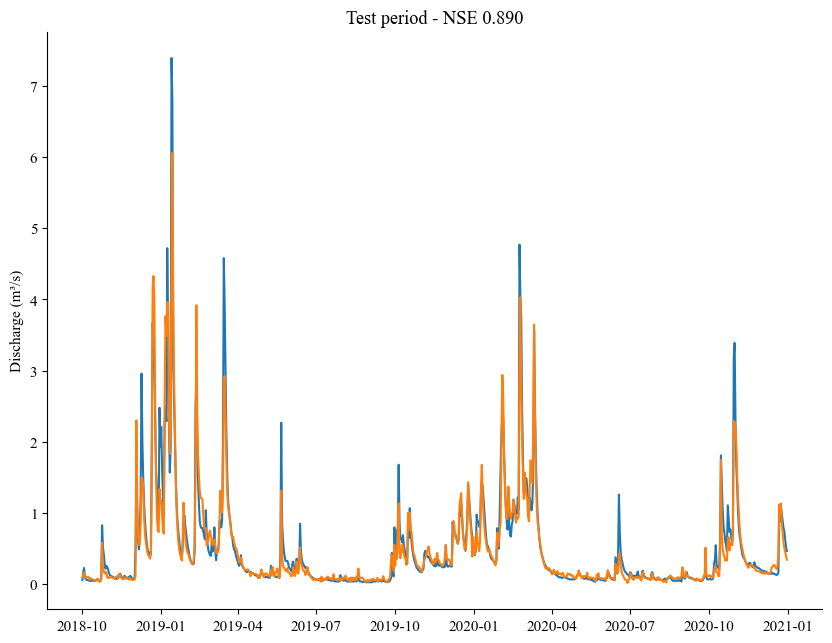

In [25]:
# Extract observations and simulations
qobs = results['DE4']['1D']['xr']['discharge_vol_obs']
qsim = results['DE4']['1D']['xr']['discharge_vol_sim']

fig, ax = plt.subplots(figsize=(10,7.5))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim)
ax.set_ylabel("Discharge (m³/s)")
ax.set_title(f"Test period - NSE {results['DE4']['1D']['NSE']:.3f}")
# save figure as high resolution png
# plt.savefig('test_results.png', dpi=300)
plt.show()